In [1]:
#Pretrain a model to predict the next word and then use it to classify sentiment

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle
import spacy

In [2]:
spacy_tok = spacy.load('en')

In [8]:
PATH = 'data/aclImdb/'

TRN_PATH = 'train/all'
VAL_PATH = 'test/all'

TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

In [5]:
%ls {PATH}

imdbEr.txt  imdb.vocab  models/  README  test/  tmp/  train/


In [6]:
!find {TRN} -name '*.txt' | xargs cat | wc -w #number of words in the dataset

17486581


In [7]:
!find {VAL} -name '*.txt' | xargs cat | wc -w

5686719


In [5]:
#Tokenizing
TEXT = data.Field(lower=True, tokenize="spacy") #data is a torchtext module 
#we create a torchtext field which describes it how to preprocess a piece of text - in this case:
#lowercase everything and tokenize it with spacy

In [6]:
bs = 64; bptt = 70 
#bptt defines how many words are being processed at a time in each row of the minibatch 
#defines how many 'layers' we backprop through
#higher the number, higher the model's ability to handle long sentences

In [9]:
FILES = dict(train=TRN_PATH, validation=VAL_PATH, test=VAL_PATH)
md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=10) 
#md is from nlp.py
#TEXT is torchtext's field definition
#**FILES is the list of all the files 
#min_freq - all the words are replaced with unique integers. If there are any words that occur less than 10 times,
#call it unknown 

In [10]:
#after building the ModelData object, it automatically fills the TEXT obj. with a very important attr.:
#TEXT.vocab which stores the mapping of unique words to unique integer ids
pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl', 'wb'))

In [6]:
TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))

In [11]:
len(TEXT.vocab.itos) #vocab len

37392

In [52]:
len(md.trn_dl) #number of batches

4583

In [53]:
md.nt #number of unique tokens -vocab

37392

In [15]:
len(md.trn_ds[0].text) #number of words

20540756

In [16]:
md.trn_ds[0].text[0]

'awful'

In [101]:
TEXT.vocab.itos[23]

'movie'

In [12]:
[spacy_tok("so")]

[so]

Variable containing:
 0
[torch.cuda.LongTensor of size 1x1 (GPU 0)]

In [102]:
TEXT.vocab.itos[402]

'awful'

In [19]:
#batch 1 of size bptt x bs
next(iter(md.trn_dl))

(Variable containing:
    402    303     55  ...      74    429    697
     23      4     29  ...     122      5   1723
      3     12   3406  ...    2895    543      4
         ...            ⋱           ...         
   1809    284   1568  ...    3640     53    156
      6      5      4  ...      14      6      7
    576    175    223  ...      12   1758      6
 [torch.cuda.LongTensor of size 71x64 (GPU 0)], Variable containing:
     23
      4
     29
   ⋮   
    237
    327
   1126
 [torch.cuda.LongTensor of size 4544 (GPU 0)])

##  Training

In [18]:
em_sz = 200 #size of embedding vector 
nh = 500 #number of hidden activations per layer
nl = 3 #number of layers

In [19]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99)) #a version of adam optimizer with less momentum than the default 0.9

In [20]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

In [43]:
learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 82%|████████▏ | 3776/4583 [05:30<01:10, 11.43it/s, loss=21]  

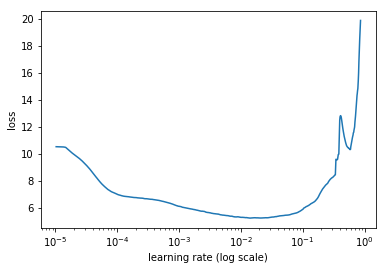

In [44]:
learner.sched.plot()

In [45]:
learner.fit(3e-3, 4, wds=1e-6, cycle_len=1, cycle_mult=2) #wds are weight decay parameters

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

  1%|▏         | 63/4583 [00:04<05:57, 12.65it/s, loss=10.4]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/abhirammv/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/abhirammv/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/abhirammv/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                                
    0      4.831873   4.716872  
    1      4.664314   4.517884                                
    2      4.547556   4.437539                                
    3      4.593736   4.466214                                
    4      4.518059   4.391605                                
    5      4.441549   4.334579                                
    6      4.398264   4.318353                                
    7      4.540455   4.409997                                
    8      4.512786   4.384997                                
    9      4.4603     4.351968                                
    10     4.42827    4.322523                                
    11     4.402844   4.292669                                
    12     4.381765   4.268633                                
    13     4.322793   4.255781                                
    14     4.329249   4.253076                                



[4.253076]

In [46]:
learner.save_encoder('adam1_enc')

In [47]:
learner.load_encoder('adam1_enc')

In [50]:
learner.fit(3e-3, 1, wds=1e-6, cycle_len=10, cycle_save_name='adam3_10')

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      4.479824   4.369461  
    1      4.481359   4.35252                                 
    2      4.45251    4.337087                                
    3      4.430039   4.313897                                
    4      4.393049   4.289252                                
    5      4.36566    4.266191                                
    6      4.321838   4.245141                                
    7      4.314127   4.232153                                
    8      4.292388   4.223741                                
    9      4.275168   4.22291                                 



[4.2229104]

In [52]:
learner.save_encoder('adam1_enc')

In [42]:
learner.load_encoder('adam1_enc')

In [55]:
learner.fit(3e-3, 1, wds=1e-6, cycle_len=5, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      4.463309   4.332439  
    1      4.417387   4.302254                                
    2      4.344901   4.258761                                
    3      4.308785   4.229368                                
    4      4.284307   4.220884                                



[4.2208843]

In [64]:
learner.save('adam10_1')

  3%|▎         | 130/4583 [00:30<17:08,  4.33it/s, loss=4.38]

In [37]:
learner.load('adam10_1') #_10

In [16]:
learner.fit(3e-3, 2, wds=1e-6, cycle_len= 1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      4.350956   4.242808  
    1      4.424917   4.27921                                 
    2      4.29904    4.227094                                



[4.2270937]

In [17]:
learner.fit(3e-3, 3, wds=1e-6, cycle_len= 1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      4.371094   4.240448  
    1      4.414724   4.277163                                
    2      4.295501   4.225137                                
    3      4.448532   4.311928                                
    4      4.37632    4.266381                                
    5      4.328625   4.224548                                
    6      4.287392   4.211473                                



[4.2114725]

In [19]:
learner.save('adam10_2')

In [23]:
learner.load('adam10_2')

In [24]:
learner.fit(3e-3, 3, wds=1e-6, cycle_len= 1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      4.352332   4.230981  
    1      4.400697   4.26963                                 
    2      4.31008    4.217494                                
    3      4.43852    4.303721                                
    4      4.383816   4.261982                                
    5      4.34206    4.219373                                
    6      4.265018   4.205584                                



[4.205584]

In [ ]:
learner.save('adam10_2')

In [32]:
learner.load('adam10_2')

In [25]:
learner.fit(3e-3, 4, wds=0.5e-6, cycle_len= 1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

  2%|▏         | 84/4583 [00:06<06:07, 12.23it/s, loss=4.34]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/abhirammv/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/abhirammv/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/abhirammv/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                                
    0      4.351176   4.223787  
    1      4.384921   4.243979                                
    2      4.274308   4.196245                                
    3      4.404579   4.273623                                
    4      4.332089   4.228754                                
    5      4.298131   4.191189                                
    6      4.221204   4.179855                                
    7      4.405437   4.27593                                 
    8      4.387236   4.264753                                
    9      4.346705   4.2431                                  
    10     4.306035   4.21788                                 
    11     4.26639    4.195202                                
    12     4.259955   4.179587                                
    13     4.254017   4.1695                                  
    14     4.217092   4.166831                                



[4.1668315]

In [26]:
learner.save('adam_15_final')

In [47]:
learner.load('adam_15_final')

In [29]:
learner.save_encoder('adam_15_enc')

In [26]:
learner.load_encoder('adam_15_enc')

In [60]:
pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl','wb'))

In [36]:
learner.summary

<bound method Learner.summary of SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(37392, 200, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(37392, 200, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(200, 500, dropout=0.05)
      )
      (1): WeightDrop(
        (module): LSTM(500, 500, dropout=0.05)
      )
      (2): WeightDrop(
        (module): LSTM(500, 200, dropout=0.05)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=200, out_features=37392)
    (dropout): LockedDropout(
    )
  )
)>

## Test - Sampling

In [123]:
spacy.load('en')

_FirstSetError: 

In [48]:
m=learner.model
ss=""". So, it wasn't quite was I was expecting, but I really liked it anyway! The best"""
s = [spacy_tok(ss)]
t=TEXT.numericalize(s)

In [49]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res,*_ = m(t)
# Put the batch size back to what it was
m[0].bs=bs

In [50]:
nexts = torch.topk(res[-1], 10)[1]
[TEXT.vocab.itos[o] for o in to_np(nexts)]

['<unk>', ',', ')', 'and', '.', '"', 'the', '-', '<eos>', '(']

In [51]:
print(ss,"\n")
for i in range(50):
    n=res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

. So, it wasn't quite was I was expecting, but I really liked it anyway! The best 

, and the film is a bit of a disappointment . the film is a bit of a mess , but it 's not a bad film . it 's a good film , but it 's not a good film . <eos> i saw this movie at the toronto ...


## Testing

In [52]:
IMDB_LABEL = data.Field(sequential=False)
splits = torchtext.datasets.IMDB.splits(TEXT, IMDB_LABEL, 'data/') #using inbuilt IMDb data and creating tr, val and test

In [55]:
t = splits[0].examples[0] 

In [56]:
t.label, ' '.join(t.text[:16])

('pos',
 'though derivative , " labyrinth " still stands as the highlight of the mid - half')

In [57]:
md2 = TextData.from_splits(PATH, splits, bs)

In [58]:
m3 = md2.get_model(opt_fn, 1500, bptt, emb_sz=em_sz, n_hid=nh, n_layers=nl, 
           dropout=0.1, dropouti=0.4, wdrop=0.5, dropoute=0.05, dropouth=0.3)
m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
m3.load_encoder(f'adam_15_enc')

In [59]:
m3.clip=25.
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [60]:
m3.freeze_to(-1)
m3.fit(lrs/2, 1, metrics=[accuracy])
m3.unfreeze()
m3.fit(lrs, 1, metrics=[accuracy], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.415208   0.242963   0.903724  



HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.380693   0.240995   0.906482  



[0.24099481, 0.9064817774631179]

In [61]:
m3.fit(lrs, 7, metrics=[accuracy], cycle_len=2, cycle_save_name='imdb2')

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.367738   0.220056   0.914378  
    1      0.358722   0.212387   0.917455                    
    2      0.354423   0.207013   0.920309                    
    3      0.307808   0.201405   0.922762                    
    4      0.309842   0.201042   0.924568                    
    5      0.295263   0.199594   0.925088                    
    6      0.318258   0.197753   0.926271                    
    7      0.315335   0.194762   0.928261                    
    8      0.31212    0.188595   0.930051                    
    9      0.289671   0.186456   0.93105                     
    10     0.300939   0.196344   0.928589                    
    11     0.275971   0.185833   0.932009                    
    12     0.283657   0.196846   0.928461                    
    13     0.277242   0.186751   0.932425                    



[0.18675095, 0.9324248721227621]

In [62]:
accuracy_np(*m3.predict_with_targs())

0.9326